In [1]:
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import numpy as np

##
# Load data, normalize, and print model-ready Data
##

data = pd.read_csv('imputed_tract_data.csv')
col_length = data['Tract Number'].shape[0]

norm_data = pd.DataFrame(columns=data.columns.values[1:])
# normalize data
for col_name in data:
    if col_name == 'Tract Number':
        continue
        
    col = normalize(np.array(data[col_name]).reshape(-1, 1), axis=0)
    col = pd.Series(col.reshape(col_length))
    norm_data[col_name] = col

print(norm_data.shape)
norm_data.head()

(2308, 39)


,Average Rent Price,Population Under Age 18,Population Ages 18-24,Population Ages 25-34,Population Ages 35-44,Population Ages 45-54,Population Ages 55-64,Population Ages 65 & Older,White Population,Black Population,...,Unemployment Rate,Uninsured Rate,Overcrowded Households,Voter Turnout Rate,Pollution Burden Score,Foreclosures,Total Homeless Population,Part I Violent Crimes,Part II Crimes,Low Grocery Store Access Population
0,0.018098,0.017941,0.016413,0.015977,0.020898,0.024947,0.025178,0.018685,0.031542,0.001483,...,0.017230,0.015179,0.008062,0.018274,0.013995,0.025945,0.004078,0.004029,0.009482,0.002443
1,0.028171,0.014777,0.011306,0.017584,0.015083,0.028513,0.033924,0.022376,0.037457,0.000678,...,0.014476,0.011788,0.003856,0.020800,0.013215,0.032431,0.001020,0.002177,0.007365,0.046947
2,0.017212,0.018429,0.018271,0.025778,0.019595,0.022183,0.020061,0.012579,0.023260,0.005910,...,0.019088,0.024945,0.021109,0.017675,0.014171,0.009729,0.005608,0.005516,0.008925,0.000000
3,0.015234,0.017142,0.010457,0.018504,0.021792,0.022216,0.029491,0.020675,0.028346,0.003296,...,0.018081,0.023502,0.011722,0.019965,0.014357,0.010810,0.003569,0.007563,0.012214,0.000000
4,0.024490,0.014001,0.011844,0.015968,0.016293,0.026559,0.031920,0.027921,0.043066,0.001090,...,0.017396,0.012191,0.000307,0.021746,0.018978,0.027026,0.001784,0.003700,0.006483,0.000374


# K-Means

In [ ]:
# Run forward feature selection with K-means with balance and silhouette combined score

results_km = dict()
for k in range(2, 11):
    best_scores = []
    s_scores = []
    balance = [0] * 39
    combined_scores = []
    growing_data = pd.DataFrame()
    data_left = norm_data.copy()
    
    # consider feature selection by adding one feature at a time
    for num_features in range(1, 40):
        best_feature = -1
        best_score = 0
        s_score = 0
        
        # get score for each feature 
        for col in data_left.columns.values:
            this_data = growing_data.copy()
            this_data[col] = norm_data[col]
        
            kmeans = KMeans(n_clusters=k, random_state=5, n_init=50).fit(this_data)
            score = silhouette_score(this_data, kmeans.labels_)
            
            # get cluster labels for each census tract
            labels = []
            for num_clust in range(k):
                these_labs = [x == num_clust for x in kmeans.labels_]
                this_class = data[these_labs]
                
                labels.append(this_class.shape[0])
            
            small_class = np.amin(labels)
        
            this_balance = small_class * (k/2308)
            combined_score = this_balance * score
        
            # update best combined score
            if combined_score > best_score:
                best_score = combined_score
                best_feature = col
                s_score = score
                balance[num_features-1] = this_balance
            
        # add best score to list of scores
        growing_data[best_feature] = norm_data[best_feature]
        data_left = data_left.drop([best_feature], axis=1)
    
        best_scores.append(best_score)
        best_features.append(best_feature)
        s_scores.append(s_score)

    
    results_km[k] = [best_scores, best_features, balance, s_scores] 

In [22]:
km_best_scores_k = []
for k in range(2, 11):
    best_score = 0
    num_feat = 0
    for i, score in enumerate(results_km[k][0]):
        if score > best_score:
            best_score = score
            num_feat = i
    
    km_best_scores_k.append(best_score)
    print(k, best_score)

2 0.6231673834144764
3 0.5680159255814481
4 0.5115748156683553
5 0.5272485532426715
6 0.4570232162853429
7 0.4740583983030088
8 0.48678599415886326
9 0.43877213726908737
10 0.4422615902252074


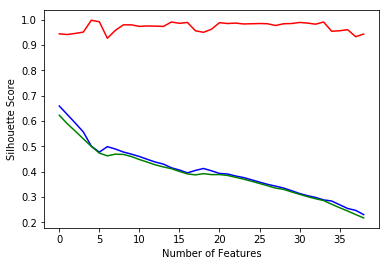

In [39]:
import matplotlib.pyplot as plt

plt.plot(range(0, 39), results_km[2][3], color='blue')
plt.plot(range(0, 39), results_km[2][2], color='red')
plt.plot(range(0, 39), results_km[2][0], color='green')
plt.xlabel('Number of Features')
plt.ylabel('Silhouette Score')
plt.show()

In [8]:
for i in range(39):
    print(i, results_km[3][i], results_km[1][i], results_km[2][i])

0 0.6597570279452347 Hispanic Population 0.9445407279029463
1 0.6260881710560169 PM2.5 Concentration 0.9419410745233969
2 0.5922910421547202 Voter Turnout Rate 0.9462738301559792
3 0.5572304951285494 Average Commute Time 0.951473136915078
4 0.5012643448745836 Average Rent Price 0.9982668977469671
5 0.4774927025689415 Uninsured Rate 0.9922010398613518
6 0.499271072763015 High School Dropout Percentage 0.9272097053726169
7 0.48997618662426023 College graduate Percentage 0.9584055459272097
8 0.47810066979072235 Population Under Age 18 0.9800693240901213
9 0.4697639093604638 Rent-Burdened Population 0.9800693240901213
10 0.46040321138888896 Population Ages 45-54 0.9740034662045061
11 0.44905754073797327 Population Ages 35-44 0.975736568457539
12 0.43832728757588113 Population Ages 55-64 0.9748700173310225
13 0.4303479344923733 Married Percentage 0.9740034662045061
14 0.41583023208585834 Population Ages 65 & Older 0.9913344887348353
15 0.40702736575602533 Pollution Burden Score 0.9861351819

# Spectral Clustering

In [27]:
# Run forward feature selection with Spectral Clustering with balance and silhouette combined score

results_sc = dict()
for k in range(2, 11):
    best_scores = []
    s_scores = []
    balance = [0] * 39
    combined_scores = []
    growing_data = pd.DataFrame()
    data_left = norm_data.copy()
    
    # consider feature selection by adding one feature at a time
    for num_features in range(1, 40):
        best_feature = -1
        best_score = 0
        s_score = 0
        
        # get score for each feature 
        for col in data_left.columns.values:
            this_data = growing_data.copy()
            this_data[col] = norm_data[col]
        
            clustering = SpectralClustering(n_clusters=k, random_state=5, affinity='laplacian', n_jobs=-1).fit(this_data)
            score = silhouette_score(this_data, clustering.labels_)
            
            # get cluster labels for each census tract
            labels = []
            for num_clust in range(k):
                these_labs = [x == num_clust for x in clustering.labels_]
                this_class = data[these_labs]
                
                labels.append(this_class.shape[0])
            
            small_class = np.amin(labels)
        
            this_balance = small_class * (k/2308)
        
            combined_score = this_balance * score
        
            # update best combined score
            if combined_score > best_score:
                best_score = combined_score
                best_feature = col
                s_score = score
                balance[num_features-1] = this_balance
        
        if best_feature == -1:
            print(k, this_balance, s_score)
            
        # add best score to list of scores
        growing_data[best_feature] = norm_data[best_feature]
        data_left = data_left.drop([best_feature], axis=1)    
        best_scores.append(best_score)
        best_features.append(best_feature)
        s_scores.append(s_score)

    
    results_sc[k] = [best_scores, best_features, balance, s_scores] 
    print(k, 'done')

2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done


In [30]:
sc_best_scores_k = []
for k in range(2, 11):
    best_score = 0
    num_feat = 0
    for i, score in enumerate(results_sc[k][0]):
        if score > best_score:
            best_score = score
            num_feat = i
    
    sc_best_scores_k.append(best_score)
    print(k, best_score)

2 0.6356945281139578
3 0.4546771005902513
4 0.416419701702005
5 0.37267675236369185
6 0.3725755683722812
7 0.38005158134290074
8 0.40875383700333523
9 0.4347082846492472
10 0.41856959366333785


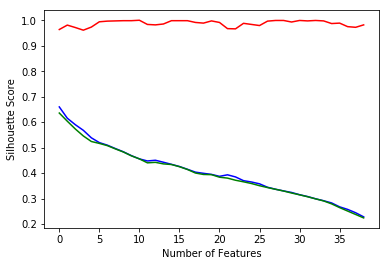

In [38]:
plt.plot(range(0, 39), results_sc[2][3], color='blue')
plt.plot(range(0, 39), results_sc[2][2], color='red')
plt.plot(range(0, 39), results_sc[2][0], color='green')
plt.xlabel('Number of Features')
plt.ylabel('Silhouette Score')
plt.show()

In [12]:
for i in range(39):
    print(i, results_sc[3][i], results_sc[1][i], results_sc[2][i])

0 0.6597045732405641 Hispanic Population 0.9636048526863085
1 0.6153431016753177 Voter Turnout Rate 0.9809358752166378
2 0.58995112687215 PM2.5 Concentration 0.9714038128249567
3 0.5678833427433013 High School Dropout Percentage 0.9610051993067591
4 0.5384574781762314 College graduate Percentage 0.9731369150779896
5 0.5196263314600995 Population Under Age 18 0.9939341421143848
6 0.5095245681864001 Average Commute Time 0.9965337954939342
7 0.4962379114351972 Rent-Burdened Population 0.9974003466204506
8 0.4835960463995131 Population Ages 45-54 0.9982668977469671
9 0.46846454508660446 Population Ages 35-44 0.9982668977469671
10 0.4556987399235441 Married Percentage 1.0
11 0.4475412202537654 Uninsured Rate 0.9835355285961872
12 0.45032445599760035 Overcrowded Households 0.9818024263431543
13 0.4425658776401193 Average Rent Price 0.9852686308492201
14 0.4343513885173709 Population Ages 55-64 0.9982668977469671
15 0.425796717328097 Pollution Burden Score 0.9982668977469671
16 0.414842766673

# Fuzzy C-Means

In [35]:
# Run forward feature selection with Fuzzy C-means with balance and silhouette combined score

results_fz = dict()
for k in range(2, 11):
    best_scores = []
    s_scores = []
    balance = [0] * 39
    combined_scores = []
    growing_data = pd.DataFrame()
    data_left = norm_data.copy()
    
    # consider feature selection by adding one feature at a time
    for num_features in range(1, 40):
        best_feature = -1
        best_score = 0
        s_score = 0
        
        # get score for each feature 
        for col in data_left.columns.values:
            this_data = growing_data.copy()
            this_data[col] = norm_data[col]
        
            cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(this_data.T, k, 2, error=0.005, maxiter=2000)
            cluster_membership = np.argmax(u, axis=0)
            score = silhouette_score(this_data, cluster_membership)
            
            # get cluster labels for each census tract
            labels = []
            for num_clust in range(k):
                these_labs = [x == num_clust for x in cluster_membership]
                this_class = data[these_labs]
                
                labels.append(this_class.shape[0])
            
            small_class = np.amin(labels)
        
            this_balance = small_class * (k/2308)
        
        
            combined_score = this_balance * score + .00001
        
            # update best combined score
            if combined_score > best_score:
                best_score = combined_score
                best_feature = col
                s_score = score
                balance[num_features-1] = this_balance
        
        if best_feature == -1:
            print(k, s_score, combined_score)
            
        # add best score to list of scores
        growing_data[best_feature] = norm_data[best_feature]
        data_left = data_left.drop([best_feature], axis=1)
        best_scores.append(best_score)
        best_features.append(best_feature)
        s_scores.append(s_score)

    
    results_fz[k] = [best_scores, best_features, balance, s_scores] 

In [36]:
fz_best_scores_k = []
for k in range(2, 11):
    best_score = 0
    num_feat = 0
    for i, score in enumerate(results_fz[k][0]):
        if score > best_score:
            best_score = score
            num_feat = i
    
    fz_best_scores_k.append(best_score)
    print(k, best_score)

2 0.6225872018737366
3 0.5580697437157298
4 0.49974241604330694
5 0.4675360094155107
6 0.46576711723283165
7 0.47036990492286024
8 0.48006902501129944
9 0.41641748970241116
10 0.4430314420679893


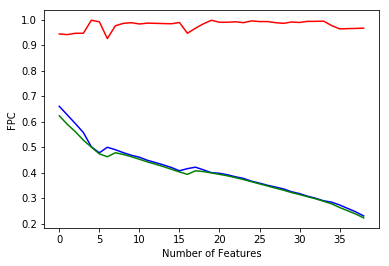

In [37]:
plt.plot(range(0, 39), results_fz[2][3], color='blue')
plt.plot(range(0, 39), results_fz[2][2], color='red')
plt.plot(range(0, 39), results_fz[2][0], color='green')
plt.xlabel('Number of Features')
plt.ylabel('FPC')
plt.show()

In [15]:
for i in range(39):
    print(i, results_fz[3][i], results_fz[1][i], results_fz[2][i])

0 0.6597374572656494 Hispanic Population 0.9436741767764298
1 0.626077981824227 PM2.5 Concentration 0.9410745233968805
2 0.5922910421547202 Voter Turnout Rate 0.9462738301559792
3 0.5572228421917146 Average Commute Time 0.9462738301559792
4 0.5012338948117186 Average Rent Price 0.9974003466204506
5 0.47747952967606655 Uninsured Rate 0.9913344887348353
6 0.49927331859816626 High School Dropout Percentage 0.925476603119584
7 0.4896545708436171 College graduate Percentage 0.975736568457539
8 0.47801293377996595 Population Under Age 18 0.9852686308492201
9 0.4678716895762959 Population Ages 45-54 0.988734835355286
10 0.4602413759039384 Rent-Burdened Population 0.9826689774696707
11 0.4480969708927182 Population Ages 55-64 0.9861351819757366
12 0.439358380434616 Married Percentage 0.9852686308492201
13 0.4300110386157802 Population Ages 35-44 0.9844020797227037
14 0.4199073552651827 Pollution Burden Score 0.9835355285961872
15 0.4069647801893618 Population Ages 65 & Older 0.988734835355286


# final selection

In [58]:
km_feats = results_km[2][1][:20]
sc_feats = results_sc[2][1][:22]
fz_feats = results_fz[2][1][:19]

all_features_df = pd.DataFrame()
for feat in sc_feats:
    if (feat in km_feats) and (feat in fz_feats):
        all_features_df[feat] = norm_data[feat]
        

In [59]:
all_features_df.columns

Index(['Hispanic Population', 'PM2.5 Concentration', 'Voter Turnout Rate',
       'Average Commute Time', 'Average Rent Price', 'Uninsured Rate',
       'High School Dropout Percentage', 'College graduate Percentage',
       'Population Under Age 18', 'Population Ages 45-54',
       'Rent-Burdened Population', 'Population Ages 55-64',
       'Married Percentage', 'Population Ages 35-44', 'Pollution Burden Score',
       'Population Ages 65 & Older', 'Overcrowded Households',
       'White Population'],
      dtype='object')

In [60]:
# print scores with selected features

kmeans = KMeans(n_clusters=2, random_state=5, n_init=50).fit(all_features_df)
score = silhouette_score(all_features_df, kmeans.labels_)
print('kmeans score:', score)

clustering = SpectralClustering(n_clusters=2, random_state=5, affinity='laplacian', n_jobs=-1).fit(all_features_df)
score = silhouette_score(all_features_df, clustering.labels_)
print('spectral score:', score)

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(all_features_df.T, 2, 2, error=0.005, maxiter=2000)
cluster_membership = np.argmax(u, axis=0)
score = silhouette_score(all_features_df, cluster_membership)
print('fuzz score:', score)

kmeans score: 0.42210352193337547
spectral score: 0.42065905358060435
fuzz score: 0.421144062688829


In [62]:
# Print Results

from prettytable import PrettyTable

kmeans = KMeans(n_clusters=2, random_state=5, n_init=50).fit(all_features_df)
score = silhouette_score(all_features_df, kmeans.labels_)

labels0 = [x == 0 for x in kmeans.labels_]
class0 = data[labels0]

labels1 = [x == 1 for x in kmeans.labels_]
class1 = data[labels1]

table = PrettyTable(['Feature', 'Average for Cluster 1', 'Median for Cluster 1', 'Average for Cluster 2', 'Median for Cluster 2'])
for col in data:
    if col == 'Tract Number':
        continue
    
    table.add_row([col, round(class0[col].mean(), 2), round(class0[col].median(), 2), round(class1[col].mean(), 2), round(class1[col].median(), 2)])

print('score:', score)
print('class 1 size:', len(class1))
print('class 0 size:', len(class0))
print(table)

score: 0.42210352193337547
class 1 size: 1215
class 0 size: 1093
+-----------------------------------------+-----------------------+----------------------+-----------------------+----------------------+
|                 Feature                 | Average for Cluster 1 | Median for Cluster 1 | Average for Cluster 2 | Median for Cluster 2 |
+-----------------------------------------+-----------------------+----------------------+-----------------------+----------------------+
|            Average Rent Price           |        1566.73        |       1510.14        |         1099.6        |       1064.71        |
|         Population Under Age 18         |         19.08         |        19.91         |         27.38         |        27.31         |
|          Population Ages 18-24          |          8.95         |         7.99         |         11.66         |        11.53         |
|          Population Ages 25-34          |         14.85         |        13.08         |         15.99   